In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.autograd import Variable
import os
from metal.mmtl.cxr.analysis.notebooks.cxr_analysis import load_log_json, load_results_from_log
from metal.mmtl.cxr.cxr_tasks import create_tasks_and_payloads

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#model_log = '/home/jdunnmon/Research/repos/metal/logs/2019_04_28/test_pneumo_slice_model_naive_10_22_22'
#model_log = '/home/jdunnmon/Research/repos/metal/logs/2019_04_28/test_pneumo_slice_model_hps_10_19_59'
#model_log = '/home/jdunnmon/Research/repos/metal/logs/2019_04_28/test_pneumo_slice_model_22_19_24'
model_log = '/lfs/1/jdunnmon/repos/metal/logs/2019_05_02/sps_drain_slice_neg_test_fine_tune_all_pneumo_10_16_56'
model = torch.load(os.path.join(model_log,'model.pkl'))

In [3]:
#os.environ['CXRDATA']='/data/datasets/mmtl/cxr/'
#os.environ['CXR8IMAGES']='/data/datasets/nih/images/images'
os.environ['CXRDATA']='/dfs/scratch0/jdunnmon/data/mmtl/cxr'
os.environ['CXR8IMAGES']='/lfs/1/jdunnmon/data/nih/images/images'
log_jsons = load_results_from_log(model_log)
log_jsons['task_config']['subsample'] = -1
log_jsons['task_config']['eval_finding'] = 'ALL'
task_names=['CXR8-DRAIN_ALL']
tasks, payloads = create_tasks_and_payloads(task_names, **log_jsons['task_config'], batch_size=32)

Could not find kwarg "finding" in destination dict.


/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Loading CXR8-DRAIN Dataset
Using train finding ALL
Using resolution 224...


/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Using dataset seed: 1701
Using eval finding ALL
Using resolution 224...
Using dataset seed: 1701
Using eval finding ALL
Using resolution 224...
Using dataset seed: 1701
Added label_set with 78468/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind to payload CXR8-DRAIN_train.
Added label_set with 62608/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred to payload CXR8-DRAIN_train.
Added label_set with 78468/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:BASE:ind to payload CXR8-DRAIN_train.
Added label_set with 78468/78468 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:BASE:pred to payload CXR8-DRAIN_train.
Added label_set with 11259/11259 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:ind to payload CXR8-DRAIN_valid.
Added label_set with 10923/11259 labels for task CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred to payload CXR8-DRAIN_valid.
Added label_set with 11259/11259 labels for task CXR8-DRAIN_PNEUMO

In [4]:
eval_tasks = {'CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred':'NO CHEST DRAINS',
              'CXR8-DRAIN_PNEUMOTHORAX':'ALL'}
model.cuda()
Ys, Ys_probs, Ys_preds = model.predict_with_gold(payloads[1],
    target_tasks=eval_tasks.keys(),
    target_labels=eval_tasks.keys(),
    return_preds=True)

In [19]:
from metal.metrics import roc_auc_score, prc_auc_score
fpr = {}
tpr = {}
thresh = {}
scores = {}
prc = {}
rec = {}
for score_task in eval_tasks.keys():
    scorer = model.task_map[score_task].scorer
    scorer.standard_metrics = ['f1','roc-auc','prc-auc','accuracy','precision','recall']
    print(f"Scoring {score_task}")
    scores[score_task] = scorer.score(
                    Ys[score_task],
                    Ys_probs[score_task],
                    Ys_preds[score_task],
                    #target_metrics=target_metrics[label_name],
                )
    print(scores[score_task])
    fpr[score_task], tpr[score_task], thresh[score_task] = roc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_roc=True)
    prc[score_task], rec[score_task], _ = prc_auc_score(Ys[score_task],Ys_probs[score_task],ignore_in_gold=[0],return_prc=True)
    

Scoring CXR8-DRAIN_PNEUMOTHORAX_slice:chest_drain_cnn_neg:pred
{'f1': 0.11019283746556476, 'roc-auc': 0.7748994938798952, 'prc-auc': 0.5313466368395185, 'accuracy': 0.97042936922091, 'precision': 0.12903225806451613, 'recall': 0.09615384615384616}
Scoring CXR8-DRAIN_PNEUMOTHORAX
{'f1': 0.42162162162162165, 'roc-auc': 0.8843707539595399, 'prc-auc': 0.6980156885114633, 'accuracy': 0.9524824584776623, 'precision': 0.5118110236220472, 'recall': 0.3584558823529412}


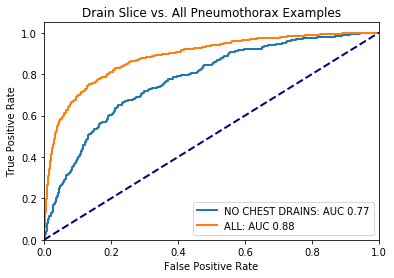

In [20]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
for score_task in eval_tasks:
    plt.plot(fpr[score_task], tpr[score_task],
             lw=lw, label=f'{eval_tasks[score_task]}: AUC %0.2f' % scores[score_task]['roc-auc'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Drain Slice vs. All Pneumothorax Examples')
plt.legend(loc="lower right")
plt.show()

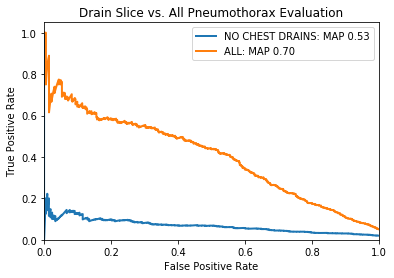

In [21]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
for score_task in eval_tasks:
    plt.plot(rec[score_task], prc[score_task],
             lw=lw, label=f'{eval_tasks[score_task]}: MAP %0.2f' % scores[score_task]['prc-auc'])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Drain Slice vs. All Pneumothorax Evaluation')
plt.legend(loc="upper right")
plt.show()